In [1]:
import pandas as pd

# 데이터 세트 호출
m_df = pd.read_csv('./datasets/medical_insurance.csv', low_memory=False)
m_df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
2767,47,female,45.320,1,no,southeast,8569.86180
2768,21,female,34.600,0,no,southwest,2020.17700
2769,19,male,26.030,1,yes,northwest,16450.89470
2770,23,male,18.715,0,no,northwest,21595.38229


#### 📊 데이터 탐색

In [2]:
m_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       2772 non-null   int64  
 1   sex       2772 non-null   object 
 2   bmi       2772 non-null   float64
 3   children  2772 non-null   int64  
 4   smoker    2772 non-null   object 
 5   region    2772 non-null   object 
 6   charges   2772 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 151.7+ KB


In [3]:
m_df.sex.value_counts()

sex
male      1406
female    1366
Name: count, dtype: int64

In [4]:
m_df.region.value_counts()

region
southeast    766
southwest    684
northwest    664
northeast    658
Name: count, dtype: int64

#### 📊 데이터 전처리

In [5]:
# 결측치 확인
m_df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [6]:
# 중복행 확인
m_df.duplicated().sum()

1435

In [7]:
# 중복행 제거
pre_m_df = m_df.drop_duplicates().reset_index(drop=True)
# 중복행 제거 확인
pre_m_df.duplicated().sum()

0

array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'bmi'}>],
       [<Axes: title={'center': 'children'}>,
        <Axes: title={'center': 'charges'}>]], dtype=object)

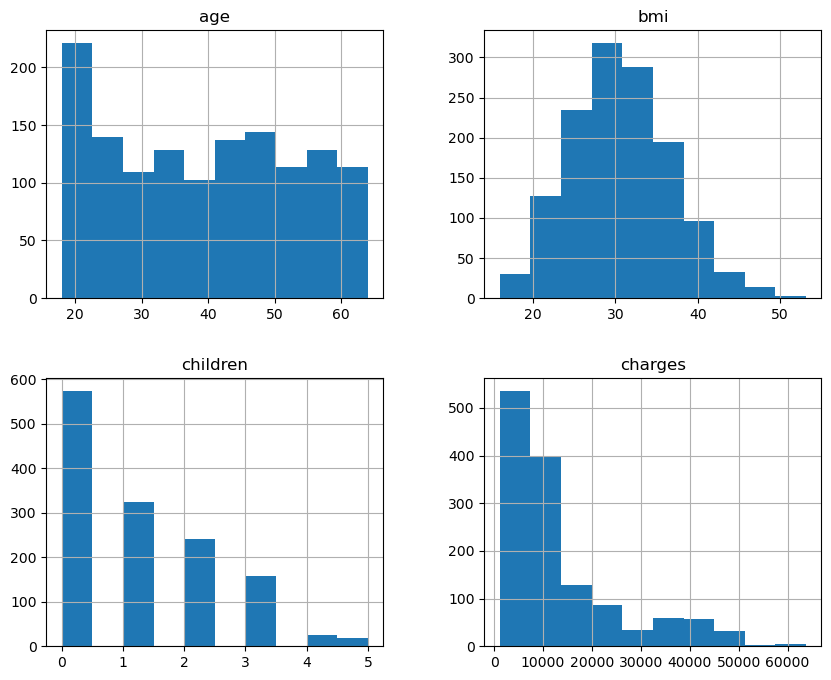

In [8]:
# 데이터 분포 확인
pre_m_df.hist(figsize=(10, 8))

In [9]:
# 타겟 컬럼 분포 변환
from sklearn.preprocessing import PowerTransformer

ptf = PowerTransformer(standardize=False)
pre_m_df['charges'] = ptf.fit_transform(pre_m_df[['charges']])
pre_m_df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,12.112778
1,18,male,33.770,1,no,southeast,8.800475
2,28,male,33.000,3,no,southeast,10.136186
3,33,male,22.705,0,no,northwest,12.517696
4,32,male,28.880,0,no,northwest,9.934782
...,...,...,...,...,...,...,...
1332,50,male,30.970,3,no,northwest,11.409771
1333,18,female,31.920,0,no,northeast,9.141534
1334,18,female,36.850,0,no,southeast,8.721757
1335,21,female,25.800,0,no,southwest,9.010493


<Axes: >

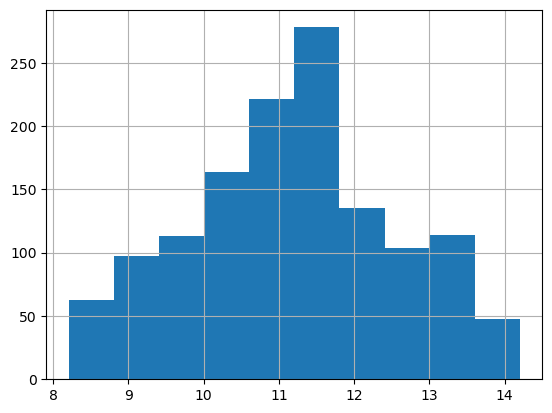

In [10]:
# 타겟 컬럼 분포 변환 확인
pre_m_df.charges.hist()

In [11]:
from sklearn.preprocessing import LabelEncoder

# 데이터 프레임 복제
enc_m_df = pre_m_df.copy()
encoders = {}

# 문자열 컬럼 추출
columns = ['sex', 'smoker']

# 반복하여 컬럼 인코딩 처리:
for column in columns:
    # 레이블인코더 객체 생성
    encoder = LabelEncoder()
    # 문자열 데이터 정수로 형변환
    result = encoder.fit_transform(enc_m_df[column])
    # 형변환 값으로 대체
    enc_m_df[column] = result
    # 원본 데이터 담기
    encoders[column] = encoder.classes_

# 원본 데이터 확인
print(encoders)

{'sex': array(['female', 'male'], dtype=object), 'smoker': array(['no', 'yes'], dtype=object)}


In [12]:
# 지역 데이터 확인
enc_m_df.region.unique()

array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

In [13]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder

# 원 핫 인코더 객체 생성
# sparse_output: False = 밀집행렬(실제 값으로 채워진 행렬) 반환
one_hot_encoder = OneHotEncoder(sparse_output=False)
# 지역 피처 인코딩 처리
result = one_hot_encoder.fit_transform(enc_m_df[['region']])

# 인코딩 값 데이터 프레임으로 생성하고 정수로 형변환한 뒤, 기존 데이터 프레임과 병합
enc_m_df = pd.concat([enc_m_df, pd.DataFrame(result, columns=one_hot_encoder.categories_).astype(np.int8)], axis=1)

# 사용이 끝난 데이터 제거
enc_m_df = enc_m_df.drop(labels='region', axis=1)

# 원 핫 인코딩 컬럼명 변경
enc_m_df.rename(columns={
    ('northeast',): 'northeast',
    ('northwest',): 'northwest',
    ('southeast',): 'southeast',
    ('southwest',): 'southwest',
}, inplace=True)

enc_m_df

,age,sex,bmi,children,smoker,charges,northeast,northwest,southeast,southwest
0,19,0,27.900,0,1,12.112778,0,0,0,1
1,18,1,33.770,1,0,8.800475,0,0,1,0
2,28,1,33.000,3,0,10.136186,0,0,1,0
3,33,1,22.705,0,0,12.517696,0,1,0,0
4,32,1,28.880,0,0,9.934782,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
1332,50,1,30.970,3,0,11.409771,0,1,0,0
1333,18,0,31.920,0,0,9.141534,1,0,0,0
1334,18,0,36.850,0,0,8.721757,0,0,1,0
1335,21,0,25.800,0,0,9.010493,0,0,0,1


In [14]:
# 타겟 컬럼 위치 변경을 위해 새로운 컬럼에 데이터 담기
enc_m_df['target'] = enc_m_df.charges
# 기존 컬럼은 제거
enc_m_df = enc_m_df.drop(labels='charges', axis=1)
enc_m_df

,age,sex,bmi,children,smoker,northeast,northwest,southeast,southwest,target
0,19,0,27.900,0,1,0,0,0,1,12.112778
1,18,1,33.770,1,0,0,0,1,0,8.800475
2,28,1,33.000,3,0,0,0,1,0,10.136186
3,33,1,22.705,0,0,0,1,0,0,12.517696
4,32,1,28.880,0,0,0,1,0,0,9.934782
...,...,...,...,...,...,...,...,...,...,...
1332,50,1,30.970,3,0,0,1,0,0,11.409771
1333,18,0,31.920,0,0,1,0,0,0,9.141534
1334,18,0,36.850,0,0,0,0,1,0,8.721757
1335,21,0,25.800,0,0,0,0,0,1,9.010493


### 🌟 1Cycle

#### 📊 회귀

In [15]:
import numpy as np
from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score

def get_evaluation(y_test, prediction):
    MSE = mean_squared_error(y_test, prediction)
    RMSE = np.sqrt(MSE)
    MSLE =  mean_squared_log_error(y_test, prediction)
    RMSLE = np.sqrt(MSLE)
    R2 = r2_score(y_test, prediction)
    print('MSE: {:.4f}, RMSE: {:.4f}, MSLE: {:.4f}, RMSLE: {:.4f}, R2: {:.4f}'\
         .format(MSE, RMSE, MSLE, RMSLE, R2))

In [16]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# 데이터 세트 분리
# 피처, 타겟 데이터 분리
features, targets = enc_m_df.iloc[:, :-1], enc_m_df.iloc[:, -1]

# 학습/테스트 및 문제/정답 데이터 세트 분리
X_train, X_test, y_train, y_test = \
train_test_split(features, targets, test_size=0.2, random_state=124)

# 선형 회귀 모델
l_r = LinearRegression()
# 훈련
l_r.fit(X_train, y_train)

LinearRegression()

In [17]:
# 예측
prediction = l_r.predict(X_test)
# 평가
get_evaluation(y_test, prediction)

MSE: 0.4515, RMSE: 0.6719, MSLE: 0.0030, RMSLE: 0.0552, R2: 0.7668


#### 📊 다중 회귀

In [18]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

# 데이터 세트 분리
# 피처, 타겟 데이터 분리
features, targets = enc_m_df.iloc[:, :-1], enc_m_df.iloc[:, -1]

# 차원 확장 (3차원)
poly_features = PolynomialFeatures(degree=3).fit_transform(features)

# 학습/테스트 및 문제/정답 데이터 세트 분리
X_train, X_test, y_train, y_test = \
train_test_split(poly_features, targets, test_size=0.2, random_state=124)

# 선형 회귀 모델
l_r = LinearRegression()
# 훈련
l_r.fit(X_train, y_train)

LinearRegression()

In [19]:
# 예측
prediction = l_r.predict(X_test)
# 평가
get_evaluation(y_test, prediction)

MSE: 0.3475, RMSE: 0.5895, MSLE: 0.0024, RMSLE: 0.0490, R2: 0.8206


####  📊 회귀 모델

In [20]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split

# 데이터 세트 분리
# 피처, 타겟 데이터 분리
features, targets = enc_m_df.iloc[:, :-1], enc_m_df.iloc[:, -1]

# 학습/테스트 및 문제/정답 데이터 세트 분리
X_train, X_test, y_train, y_test = \
train_test_split(features, targets, test_size=0.2, random_state=124)

# 회귀 모델 담기
dt_r = DecisionTreeRegressor(random_state=124)
rf_r = RandomForestRegressor(random_state=124, n_estimators=1000)
gb_r = GradientBoostingRegressor(random_state=124)
xgb_r = XGBRegressor(random_state=124)
lgb_r = LGBMRegressor(random_state=124)

models = [dt_r, rf_r, gb_r, xgb_r, lgb_r]

# 모델 별 학습 진행:
for model in models:
    # 모델 학습
    model.fit(X_train, y_train)
    # 예측
    prediction = model.predict(X_test)
    # 모델명 출력 (모델명과 평가 결과가 같이 출력되도록)
    print(model.__class__.__name__)
    # 평가
    get_evaluation(y_test, prediction)

DecisionTreeRegressor
MSE: 0.5607, RMSE: 0.7488, MSLE: 0.0039, RMSLE: 0.0622, R2: 0.7104
RandomForestRegressor
MSE: 0.3537, RMSE: 0.5947, MSLE: 0.0025, RMSLE: 0.0500, R2: 0.8174
GradientBoostingRegressor
MSE: 0.3334, RMSE: 0.5774, MSLE: 0.0023, RMSLE: 0.0482, R2: 0.8278
XGBRegressor
MSE: 0.4027, RMSE: 0.6346, MSLE: 0.0028, RMSLE: 0.0533, R2: 0.7920
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 321
[LightGBM] [Info] Number of data points in the train set: 1069, number of used features: 9
[LightGBM] [Info] Start training from score 11.191489
LGBMRegressor
MSE: 0.3579, RMSE: 0.5983, MSLE: 0.0025, RMSLE: 0.0503, R2: 0.8152


In [21]:
cycle1_data = {
    'model': ['회귀', '다중회귀', '회귀모델(gb_r)'],
    'R2': [0.7668, 0.8206, 0.8278],
}

cycle1 = pd.DataFrame(cycle1_data)

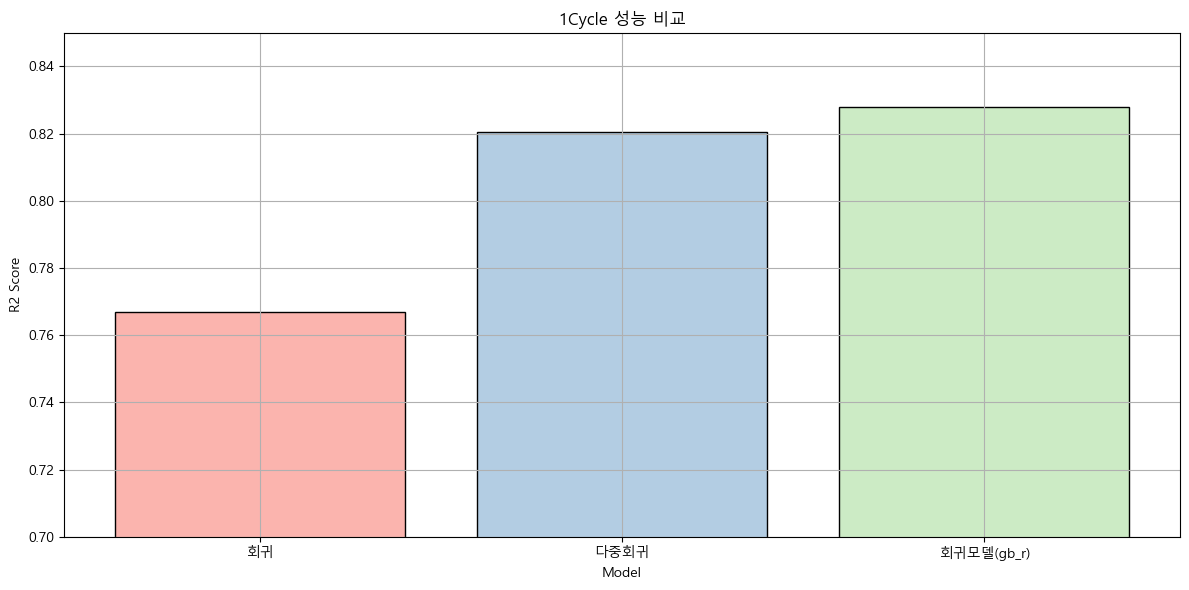

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# 한글 폰트 경로 설정
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

# 그래프 그리기
plt.figure(figsize=(12, 6))

# 컬러맵 가져오기
cmap = plt.get_cmap('Pastel1')

plt.bar(cycle1['model'], cycle1['R2'], color=cmap(np.array([0, 1, 2])), edgecolor='black')
plt.title('1Cycle 성능 비교')
plt.xlabel('Model')
plt.ylabel('R2 Score')
plt.grid(True)

# y축의 범위 지정
plt.ylim(0.7, 0.85)

plt.tight_layout()
plt.show()

#### 🚩 1Cycle 결과
- 회귀  
**MSE: 0.4515, RMSE: 0.6719, MSLE: 0.0030, RMSLE: 0.0552, R2: 0.7668**

- 다중 회귀  
**MSE: 0.3475, RMSE: 0.5895, MSLE: 0.0024, RMSLE: 0.0490, R2: 0.8206**

- 회귀 모델(GradientBoostingRegressor)  
**MSE: 0.3334, RMSE: 0.5774, MSLE: 0.0023, RMSLE: 0.0482, R2: 0.8278**

#### 💡 분석
- 회귀 분석 결과 R2 점수가 약 0.76이 나옴에 따라 선형 패턴을 지니고 있다고 보여졌으나,  
  다중 회귀로 곡선을 부여하였을 때 약 R2 점수가 0.82로 상승함에 따라 완전한 선형은 아니고 비선형의 패턴도 띄고 있음을 확인함.
- 회귀 모델 중 GradientBoostingRegressor을 사용하였을 때, 가장 좋은 성능을 보임에 따라 해당 모델을 선택하는 것이 적합하다고 판단됨.

C:\Users\LEGION\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\LEGION\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


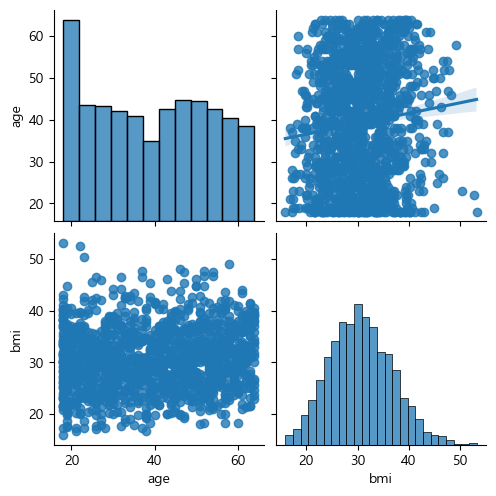

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터프레임에서 'target' 열 제외
columns = ['age', 'bmi']

# 산점도 행렬 시각화
sns.pairplot(enc_m_df[columns], kind="reg")
plt.show()

#### 🚩 결과
- 다중 공선성의 문제가 없는 것을 확인함.

array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'bmi'}>],
       [<Axes: title={'center': 'children'}>,
        <Axes: title={'center': 'charges'}>]], dtype=object)

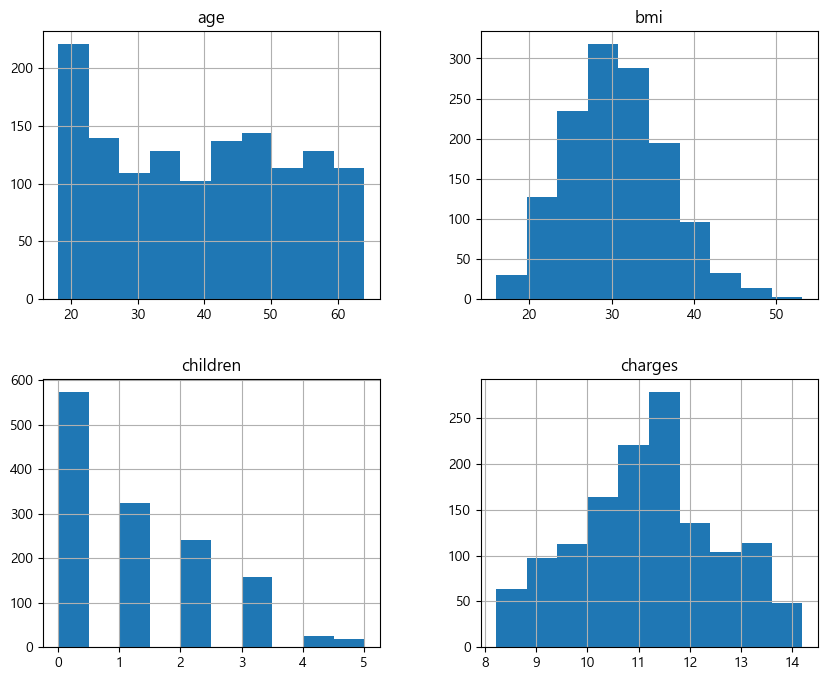

In [24]:
# 데이터 분포 확인
pre_m_df.hist(figsize=(10, 8))